# Import Necessary Libraries

In [12]:
import jsonlines
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from seqeval.scheme import IOB2
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.training.iob_utils import offsets_to_biluo_tags
import random
import json
import os
from tqdm import tqdm

# Reading Data

In [13]:
def read_jsonl_file(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for line in reader:
            data.append(line)
    return data

In [14]:
file_path = "Final_train_original_data.jsonl"
train = read_jsonl_file(file_path)
text = []
spans = []
for entry in train:
    if entry['text'] not in text:
        text.append(entry["text"])
        spans.append(entry['entities']) 

In [15]:
X_train = []
y_train = []
with open('Final_train_original_data.jsonl', 'r') as file:
    for line in file:
        obj = json.loads(line)
        X_train.append(obj['text'])
        entities_transformed = [{'start': entity[0], 'end': entity[1], 'label': entity[2]} for entity in obj['entities']]
        y_train.append(entities_transformed)
X_train

['okay I think just another point do you have physical ic and can say your ic number is it S3995288B',
 'my last four digits of my I_C is eight one one G',
 'see is there a outlet at the east area  please call them on  nine four six one eight one one one ',
 'in that case I would (err)',
 'his  ic number six eight one C',
 'will do thanks 678 90120 345 will transer to UOB okay.',
 'our fast service number is 9450-6666 please note',
 'okay (uh) my full name is janice #Teh# (uh) #Wei Ling# and ic number is G0881816 P.',
 'Kanda transfered the money to Niko OCBC account  888-20066-4. Not sure he has any account with DBS',
 "sure sure okay and then (uh) can I ask what's the last four digits of your N_R_I_C alphanumeric",
 ' a certain brand that you normally shop at then cashback would be (uh) better for you',
 'okay so (um) I look forward to hear from you again thank you so much for your call',
 'okay (ppb) so there are a few country you can consider one is thailand and taiwan another one 

In [16]:
X_test = []
y_test = []
with open('Final_test_data.jsonl', 'r') as file:
    for line in file:
        obj = json.loads(line)
        X_test.append(obj['text'])
        entities_transformed = [{'start': entity[0], 'end': entity[1], 'label': entity[2]} for entity in obj['entities']]
        y_test.append(entities_transformed)
X_test

['The day before yesterday, Ram received another email from r e m y at outlook dot sg',
 '(um) my date of birth is (uh) second september nineteen ninety two',
 'a larger amount of data do you have (uh) any (uh) like unlimited data plans or what is the max (um)',
 'she handed over a crumpled piece of paper, ther is car plate number SC9100G',
 "okay okay (uh) ya actually that's that's that's really good I think I'll go with that also do I (ppb) (uh) I I'm not sure (uh) I would like to check if I have any like outstanding",
 "(um) it's pay as you roam but I've never really (uh) used it for cause I'm not really sure (um) (uh) what are the charges like",
 '#aglio olio# and (err) (uh) three three of the other one ya',
 "Hong's email is t x 1 r z a four seven at yahoo dot com",
 'yes, Forstest car is SY8792H',
 "t a n b b at gmail dot com is BB's Gmail, do you know ?",
 '<B> ~(err) can you go with go through with me the list again',
 'bb3encv3@yahoo.com is my yahoo id but i am using Gmail now

In [17]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

788
788
196
196


In [18]:
train_data = []
for i in range(len(X_train)):
    temp2 = []
    for j in y_train[i]:
        temp2.append((j['start'], j['end'], j['label']))
    temp = (X_train[i], {"entities" : temp2}) 
    train_data.append(temp)

In [19]:
test_data1 = []
for i in range(len(X_test)):
    temp2 = []
    for j in y_test[i]:
        temp2.append((j['start'], j['end'], j['label']))
    
    temp = (X_test[i], {"entities" : temp2}) 
    test_data1.append(temp)

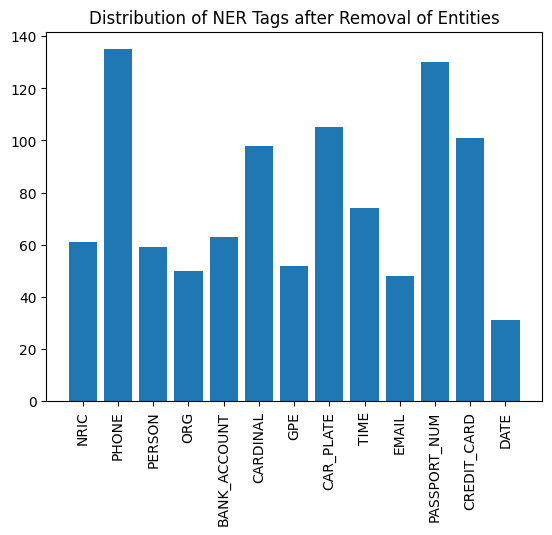

In [20]:
# Count of Labels for Train Set
labels = {}
for i in y_train:
    for j in i:
        labels[j['label']] = labels.get(j['label'], 0) + 1
labels3 = dict(sorted(labels.items(), key=lambda item: item[0]))
plt.bar(labels.keys(), labels3.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

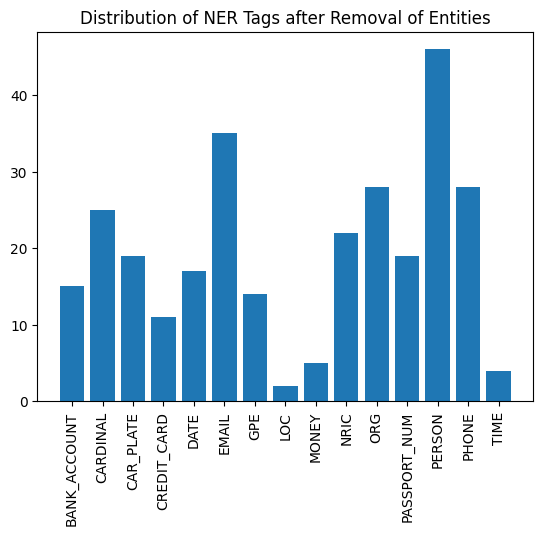

In [11]:
# Count of Labels for Test Set
labels1 = {}
for i in y_test:
    for j in i:
        labels1[j['label']] = labels1.get(j['label'], 0) + 1
labels1 = dict(sorted(labels1.items(), key=lambda item: item[0]))
plt.bar(labels1.keys(), labels1.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

# Training

In [20]:
validation_data = test_data1

In [22]:
# Load pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")
# Ensure the 'ner' pipe is in the pipeline
if "ner" not in nlp.pipe_names:
    nlp.add_pipe("ner", last=True)

# Add custom labels to the NER component
ner = nlp.get_pipe("ner")
custom_labels = ['BANK_ACCOUNT', 'CARDINAL', 'CAR_PLATE', 'CREDIT_CARD', 'DATE', 'EMAIL',
                 'GPE', 'MONEY', 'NRIC', 'ORG', 'PASSPORT_NUM', 'PERSON', 'PHONE', 'TIME']

for label in custom_labels:
    ner.add_label(label)

def fix_misaligned_entities(text, entities):
    doc = nlp.make_doc(text)
    tags = offsets_to_biluo_tags(doc, entities)
    fixed_entities = []
    for token, tag in zip(doc, tags):
        if tag.startswith('B') or tag.startswith('I') or tag.startswith('L') or tag.startswith('U'):
            ent_label = tag.split('-')[-1]
            if len(fixed_entities) == 0 or fixed_entities[-1][2] != ent_label:
                fixed_entities.append((token.idx, token.idx + len(token), ent_label))
            else:
                fixed_entities[-1] = (fixed_entities[-1][0], token.idx + len(token), ent_label)
    return {"entities": fixed_entities}

# Correct entity alignment in training data
corrected_train_data = []
for text, annotations in train_data:
    corrected_annotations = fix_misaligned_entities(text, annotations["entities"])
    corrected_train_data.append((text, corrected_annotations))

def evaluate_model(nlp, data):
    examples = []
    for text, annotations in data:
        doc = nlp.make_doc(text)
        examples.append(Example.from_dict(doc, annotations))
    scores = nlp.evaluate(examples)
    return scores

# Disable other pipes to only train NER
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    batch_sizes = compounding(4.0, 32.0, 1.001)
    dropout = 0.2  # start with a lower dropout rate

    # Training loop
    for itn in range(100):
        random.shuffle(corrected_train_data)
        losses = {}
        for batch in minibatch(corrected_train_data, size=batch_sizes):
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], drop=dropout, sgd=optimizer, losses=losses)
        print(f"Iteration {itn}: {losses}")

        # Evaluate the model periodically
        if (itn + 1) % 10 == 0:
            scores = evaluate_model(nlp, validation_data)
            print(f"Iteration {itn}: F1 Score {scores['ents_f']:.3f}")

nlp.to_disk("ner_model_org")

Iteration 0: {'ner': 1743.6980954622065}
Iteration 1: {'ner': 1353.3603445083297}
Iteration 2: {'ner': 1039.032304891642}
Iteration 3: {'ner': 878.9103196780175}
Iteration 4: {'ner': 788.0257008123821}
Iteration 5: {'ner': 721.4366559974812}
Iteration 6: {'ner': 752.451653301328}
Iteration 7: {'ner': 610.1254499545854}
Iteration 8: {'ner': 665.5192270524067}
Iteration 9: {'ner': 619.0893386817169}
Iteration 9: F1 Score 0.629
Iteration 10: {'ner': 707.6719118035526}
Iteration 11: {'ner': 548.9292825713932}
Iteration 12: {'ner': 509.09321620864404}
Iteration 13: {'ner': 409.57411676730027}
Iteration 14: {'ner': 619.6690187375364}
Iteration 15: {'ner': 459.3660952557764}
Iteration 16: {'ner': 607.1459142412061}
Iteration 17: {'ner': 438.34178654300206}
Iteration 18: {'ner': 438.0654172680358}
Iteration 19: {'ner': 381.54122314896347}
Iteration 19: F1 Score 0.546
Iteration 20: {'ner': 402.0620636772207}
Iteration 21: {'ner': 367.768052087489}
Iteration 22: {'ner': 364.9964127636605}
Iterat

# F1-Score

In [23]:
nlp = spacy.load("ner_model_org")
gold_annotations = []
for i in test_data1:
    gold_annotations.append(i[1])
predicted_annotations = []
for inst in test_data1:
    doc = nlp(inst[0])
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    predicted_annotations.append({"entities": entities})

In [24]:
# Function to determine the length of the text
def get_text_length(annotation):
    # Determine the maximum index used in the entity annotations
    if annotation['entities']:
        return max(end for _, end, _ in annotation['entities'])
    return 0

# Convert annotations to BIO format
def annotations_to_bio(annotation, text_length, labels_of_interest):
    bio_labels = ['O'] * text_length
    for start, end, label in annotation['entities']:
        if label in labels_of_interest:
            bio_labels[start] = f'B-{label}'
            for i in range(start + 1, end):
                bio_labels[i] = f'I-{label}'
    return bio_labels

# Define the labels you're interested in
labels_of_interest = ['BANK_ACCOUNT', 'CAR_PLATE', 'CREDIT_CARD', 'EMAIL', 'NRIC', 'PASSPORT_NUM', 'PHONE']

# Convert annotations to BIO format for each text
gold_labels = []
predicted_labels = []

for gold, pred in zip(gold_annotations, predicted_annotations):
    gold_text_length = get_text_length(gold)
    pred_text_length = get_text_length(pred)
    
    # Ensure both lengths are the same for each corresponding pair
    text_length = max(gold_text_length, pred_text_length)
    
    gold_labels.append(annotations_to_bio(gold, text_length, labels_of_interest))
    predicted_labels.append(annotations_to_bio(pred, text_length, labels_of_interest))

# Calculate metrics using seqeval
report = classification_report(gold_labels, predicted_labels, output_dict=True, mode='strict', scheme=IOB2)
precision = precision_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)
recall = recall_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)
f1 = f1_score(gold_labels, predicted_labels, mode='strict', scheme=IOB2)

# Convert classification report to DataFrame
df_report = pd.DataFrame(report).transpose()

print(df_report)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
    

              precision    recall  f1-score  support
BANK_ACCOUNT   0.928571  0.866667  0.896552     15.0
CAR_PLATE      0.500000  0.368421  0.424242     19.0
CREDIT_CARD    0.625000  0.909091  0.740741     11.0
EMAIL          0.769231  0.571429  0.655738     35.0
NRIC           0.680000  0.772727  0.723404     22.0
PASSPORT_NUM   0.647059  0.578947  0.611111     19.0
PHONE          0.739130  0.607143  0.666667     28.0
micro avg      0.703704  0.637584  0.669014    149.0
macro avg      0.698427  0.667775  0.674065    149.0
weighted avg   0.705882  0.637584  0.663091    149.0
Precision: 0.7037037037037037
Recall: 0.6375838926174496
F1-score: 0.6690140845070424


# Other Metrices

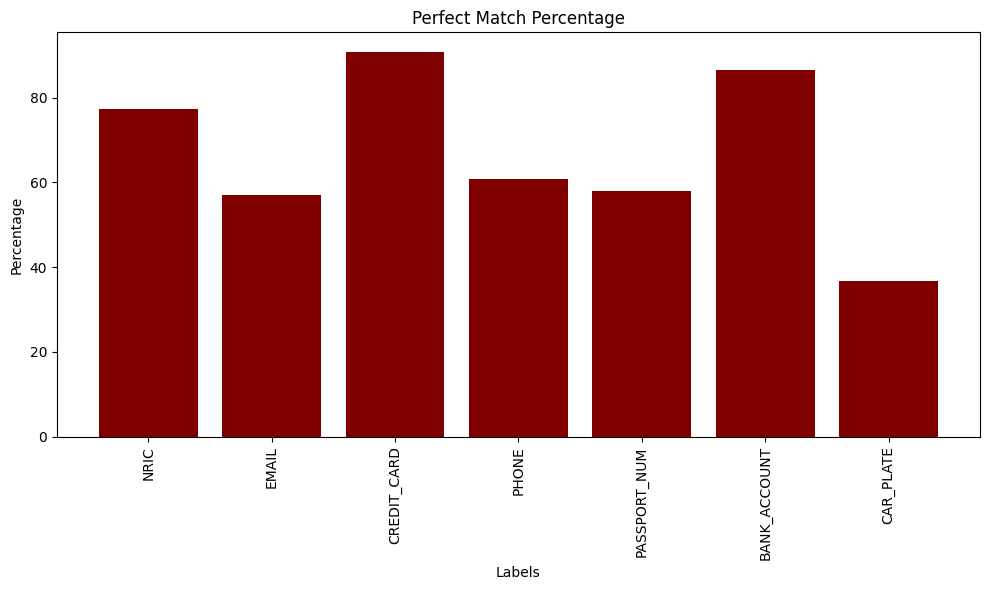

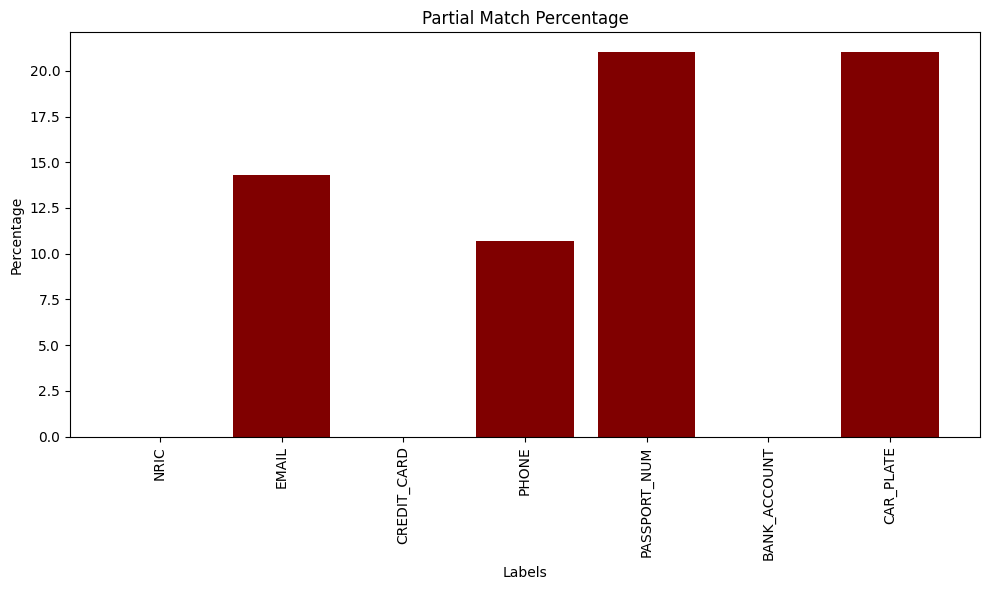

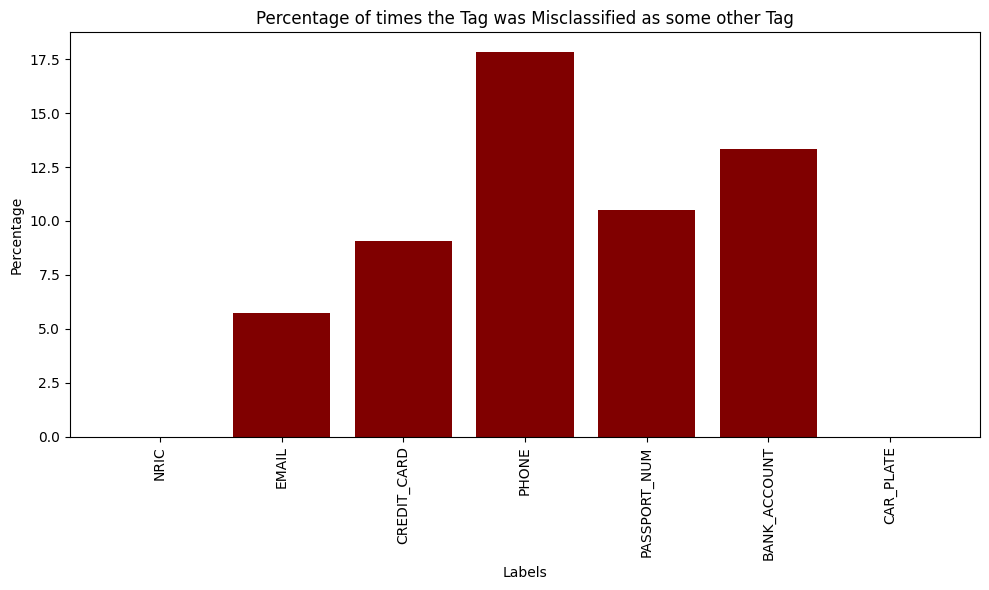

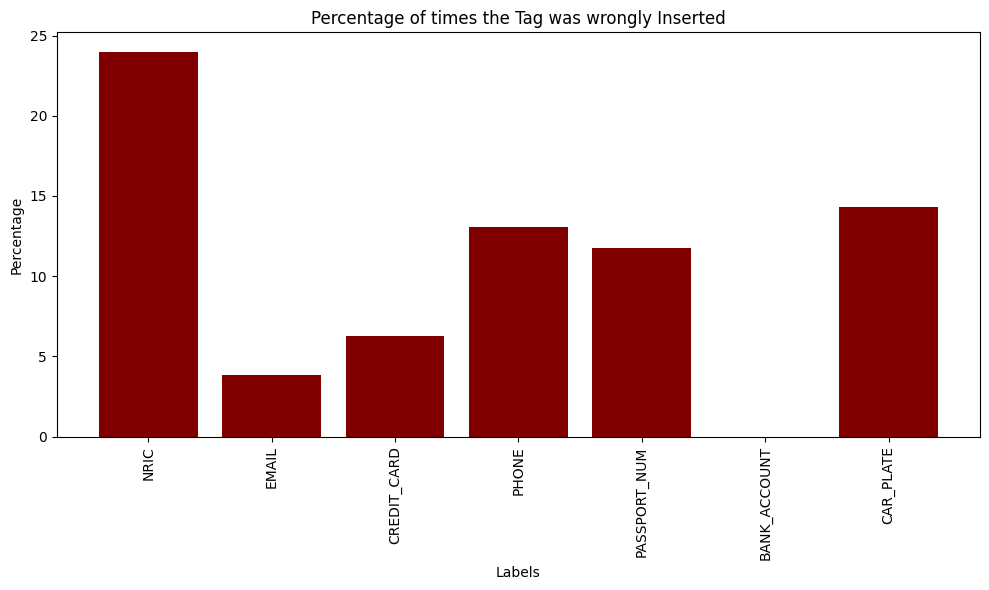

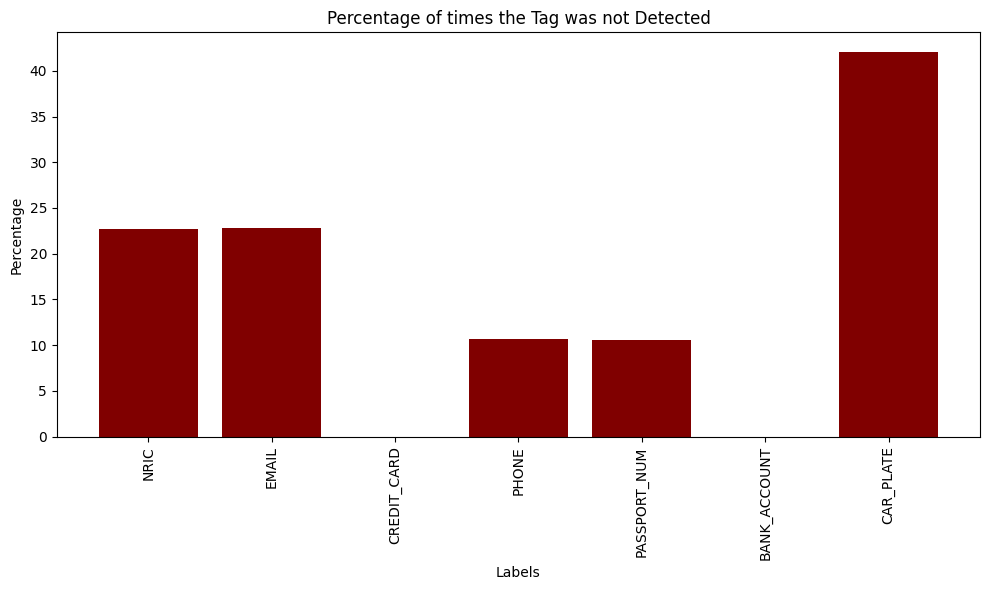

,Tag,Perfect (%),Part (%),Substituted (%),Hallucinated (%),Omitted (%)
0,NRIC,77.272727,0.000000,0.000000,24.000000,22.727273
1,EMAIL,57.142857,14.285714,5.714286,3.846154,22.857143
2,CREDIT_CARD,90.909091,0.000000,9.090909,6.250000,0.000000
3,PHONE,60.714286,10.714286,17.857143,13.043478,10.714286
4,PASSPORT_NUM,57.894737,21.052632,10.526316,11.764706,10.526316
5,BANK_ACCOUNT,86.666667,0.000000,13.333333,0.000000,0.000000
6,CAR_PLATE,36.842105,21.052632,0.000000,14.285714,42.105263


In [25]:
# Define a function to create an empty dictionary with keys from a list
def empty_dict(l):
    return {i: 0 for i in l}
# Load the NER model
nlp = spacy.load("ner_model_org")

# Extract gold and predicted annotations
gold_annotations = [i[1] for i in test_data1]
predicted_annotations = []
for inst in test_data1:
    doc = nlp(inst[0])
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    predicted_annotations.append({"entities": entities})

# Define relevant entities
relevant_entities = ["NRIC", "EMAIL", "CREDIT_CARD", "PHONE", "PASSPORT_NUM", "BANK_ACCOUNT", "CAR_PLATE"]

# Initialize dictionaries for performance metrics
perf_match = empty_dict(relevant_entities)
part_match = empty_dict(relevant_entities)
insert = empty_dict(relevant_entities)
delete = empty_dict(relevant_entities)
sub = empty_dict(relevant_entities)

# Deep copy annotations for manipulation
true = copy.deepcopy(gold_annotations)
pred = copy.deepcopy(predicted_annotations)

# Count total predicted entities for each relevant tag
predicted_counts = empty_dict(relevant_entities)
for inst in predicted_annotations:
    for entity in inst['entities']:
        if entity[2] in relevant_entities:
            predicted_counts[entity[2]] += 1

# Calculate performance metrics
for i in range(len(true)):
    for j in true[i]['entities']:
        if j[2] not in relevant_entities:
            continue

        if j in pred[i]['entities']:
            perf_match[j[2]] += 1
            pred[i]['entities'].remove(j)
        else:
            start, end, tag = j
            flag = False
            for k in pred[i]['entities'][::-1]:
                if start == k[0]:
                    flag = True
                    if tag == k[2]:
                        part_match[j[2]] += 1
                        pred[i]['entities'].remove(k)
                    else:
                        sub[j[2]] += 1
                        pred[i]['entities'].remove(k)
            if not flag:
                delete[j[2]] += 1
    for k in pred[i]['entities']:
        if k[2] in relevant_entities:
            insert[k[2]] += 1

# Initialize lists for plot data
perfect = []
part = []
substituted = []
hallucinated = []
omitted = []

# Count the number of true entities for each relevant tag
labels_count = empty_dict(relevant_entities)
for annotation in gold_annotations:
    for entity in annotation['entities']:
        if entity[2] in relevant_entities:
            labels_count[entity[2]] += 1

# Calculate percentages and append to lists
for label in relevant_entities:
    num = labels_count[label]
    predicted_num = predicted_counts[label]
    perfect.append((perf_match[label] / num) * 100 if num > 0 else 0)
    part.append((part_match[label] / num) * 100 if num > 0 else 0)
    substituted.append((sub[label] / num) * 100 if num > 0 else 0)
    hallucinated.append((insert[label] / predicted_num) * 100 if predicted_num > 0 else 0)
    omitted.append((delete[label] / num) * 100 if num > 0 else 0)

# Plot the data
lists = [perfect, part, substituted, hallucinated, omitted]
list_names = ["Perfect Match Percentage", "Partial Match Percentage", "Percentage of times the Tag was Misclassified as some other Tag", "Percentage of times the Tag was wrongly Inserted", "Percentage of times the Tag was not Detected"]

for i, data in enumerate(lists):
    plt.figure(figsize=(10, 6))
    plt.bar(relevant_entities, data, color='maroon')
    plt.xlabel('Labels')
    plt.ylabel('Percentage')
    plt.title(list_names[i])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Create a DataFrame for the metrics
data = {
    'Tag': relevant_entities,
    'Perfect (%)': perfect,
    'Part (%)': part,
    'Substituted (%)': substituted,
    'Hallucinated (%)': hallucinated,
    'Omitted (%)': omitted
}

df = pd.DataFrame(data)
df


In [26]:
overall_perfect = sum(perfect) / len(relevant_entities)
overall_part = sum(part) / len(relevant_entities)
overall_substituted = sum(substituted) / len(relevant_entities)
overall_hallucinated = sum(hallucinated)
overall_omitted = sum(omitted) / len(relevant_entities)

overall_performance = {
    'Metric': ['Overall'],
    'Perfect (%)': overall_perfect,
    'Part (%)': overall_part,
    'Substituted (%)': overall_substituted,
    'Hallucinated': overall_hallucinated,
    'Omitted (%)': overall_omitted
}

overall_df = pd.DataFrame(overall_performance)
overall_df

,Metric,Perfect (%),Part (%),Substituted (%),Hallucinated,Omitted (%)
0,Overall,66.777496,9.586466,8.07457,73.190052,15.561469
